# BATCH NORMALIZATION

Batch Normaliaztion was introduced by Sergey Ioffe and Christian Szegedy in 2015 in their paper:  
<i>[1] "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"</i>.

In 2016 Jimmy Lei Ba, Jamie Ryan Kiros and Geoffrey E. Hinton address some problems of batch normalization in their paper:  
<i>[2] "Layer Normalization"</i>.

In 2018 Yuxin Wu and Kaiming He proposed an intermediary technique in their paper:  
<i>[3] "Group Normalization"</i>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from layers import *
from utils.gradient_check import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# plot configuration
%matplotlib inline
plt.rcParams["figure.figsize"] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Machine learning methods tend to work better when their input data consists of uncorrelated features with zero mean and unit variance.  
When training a neural network, we usually preprocess the data before feeding it to the network to ensure that the first layer of the network sees data that follows a nice distribution. We could even go a step further and whiten the data to explicitly decorrelate its features. Network training converges faster if its inputs are whitened - i.e., linearly transformed to have zero means and unit variances, and decorrelated.  
However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance, since they are output from earlier layers in the network. This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonliearities.  
During the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated. This phenomenon is referred to as <i>internal covariate shift</i>

A network computing a loss function

$$ l = F_{2}(F_{1}(x, \theta_{1})), \theta_{2}) $$

can be viewed as if the inputs $ u = F_{1}(x, \theta_{1}) $ are fed into a sub-network $ l = F_{2}(u, \theta_{2}) $.

Therefore, the input distribution properties that make training more efficient apply to training the sub-network as well.

In [2]:
# Running a number of training cycles on a neural net and plotting the activations
# of each layer during each cycle.

As each layer observes the inputs produced by the layers below, it would be advantageous to achieve the same form of preprocessing of the inputs of each layer. However, if these modifications are inserted during the forward pass, then during the backward pass the gradient descent optimization has to take into account the fact that the normalization takes place.

Writing the normalization as a transformation: $ \hat{u} = Norm(u, \Psi) $, we see that for brackpopagation we need to compute the Jacobians:

$$ \displaystyle
\frac{\partial Norm(u, \Psi)}{\partial u} \space \text{and} \space  \frac{\partial Norm(u, \Psi)}{\partial \Psi} $$

Whitin this framework, whitening the layer inputs is expensive as it requires computing the covariance matrix and its inverse square root, to produce the whitened activations, as well as the derivatives of these transforms for backpropagation. Thus, it is reasonable to perform input normalization in a way that is differentiable and does not require the analysis of the entire training set after every parameter update.



In [3]:
# Wrtie some code doing whitening and time it to check how slow it actually runs.

Instead of whitening the layer inputs, we will normalize each feature by making it have zero mean and unit variance.

$$ \displaystyle
\hat{u}^{(k)} = \frac{u^{(k)} - E[u^{(k)}]}{\sqrt{Var[u^{(k)}]}}
$$

To compute the gradient, we could write out a computation graph composed of simple operations and backpropagate through all intermediate values.

![BatchNorm Graph](img/batchnorm_graph.png "BatchNorm Graph")

However, simply normalizing each input of a layer may change what the layer can represent. For instance, normalizing the inputs of a sigmoid would constrain them to the linear regime of the nonlinearity. To address this, for each activation $ u^{(k)} $ , a pair of parameters $ \gamma ^{(k)} $ and $ \beta ^{(k)} $ are introduced, which scale and shift the normalzied value:

$$ y^{(k)} = \gamma ^{(k)} \hat{u}^{(k)} + \beta ^{(k)} $$

These parameters are learned along with the original model parameters, and restore the representational power of the network. We could recover the original activations, if that were the optimal thing to do.  

In [4]:
# Write some code to show why simply normalizing is not a good idea.

## Batch Norm

To normalize the output of a given layer, we need to compute the mean and the variance of every feature in that layer.
One way to do that is to compute the value of a given feature, $ u^{(k)} $, for every training example in the dataset $ \{x_{i}\}_{i=1}^{N} $ and then compute the mean and the variance over these values:

$$ \displaystyle
\begin{align*}
& E[u^{(k)}] = \frac{1}{N} \sum_{i=1}^{N} u_{i}^{(k)} \\
& Var[u^{(k)}] = \frac{1}{N} \sum_{i=1}^{N} (u_{i}^{(k)} - E[u^{(k)}])^{2}
\end{align*}
$$

![DataSet Norm](img/batchnorm_datasetnorm.png "DataSet Norm")

However, this is impractical when using stochastic optimization with mini-batches. Instead of computing the value of every feature for every training example in the dataset, we will use only the values computed for that mini-batch. Thus, for a mini-batch of size $ m $ we have:

$$ \displaystyle
\begin{align*}
& \mu_{\beta}^{(k)} = \frac{1}{m} \sum_{i=1}^{m} u_{i}^{(k)} \\
& \upsilon_{\beta}^{(k)} = \frac{1}{m} \sum_{i=1}^{m} (u_{i}^{(k)} - \mu_{\beta}^{(k)})^{2}
\end{align*}
$$

The values $ \mu_{\beta}^{(k)} $ and $ \upsilon_{\beta}^{(k)} $ give us <b><i>estimates</i></b> of the mean and the variance of the feature $ u^{(k)} $.  
Thus, normalization for a given feature $ u^{(k)}$ takes the form:

$$ \displaystyle
\begin{align*}
& \hat{u}^{(k)} = \frac{u^{(k)} - \mu_{\beta}^{(k)}}{\sqrt{\upsilon_{\beta}^{(k)} - \epsilon}} \\
& y^{(k)} = \gamma^{(k)} \hat{u}^{(k)} + \beta^{(k)} \\
\end{align*}
$$

![BatchNorm](img/batchnorm.png "BatchNorm")

Normalizing using mini-batch statistics allows efficient training, but a question arises during testing how to cumpute the mean and the variance. During testing the mean and the variance are not computed using mini-batch statistics, because we want the output of a single training example to depend only on the training example itself, and not on the entire batch. When normalizing during testing we need to use means and variances computed over the <b><u>training set</u></b>. One way is to calculate an estimate of the mean and the variance using population statistics:

$$ \displaystyle
\begin{align*}
& E[u^{(k)}] = E_{\beta}[\mu_{\beta}^{(k)}] \\
& Var[u^{(k)}] = \frac{m}{m -1} E_{\beta}[\upsilon_{\beta}^{(k)}]
\end{align*}
$$

Once the network has been trained, we compute the means and variances for a large number of mini-batches of size $ m $, and we average over these values. Note that the unbiased estimate for the variance is used.

Using this approach, however, it is not very easy to keep track of the accuracy of the model during training. Another way for calculating the means and variances is to use <i>running averages</i>. For every feature, $ u^{(k)} $, we keep a running mean, $ \mu_{run}^{(k)} $, and a running variance, $ \upsilon_{run}^{(k)} $. At every training step we compute the sample mean, $ \mu_{\beta}^{(k)} $, and the sample variance, $ \upsilon_{\beta}^{(k)} $, for the feature $ u^{(k)} $, and we update these running averages using an exponantially decaying rule:

$$ \displaystyle
\begin{align*}
& \mu_{run}^{(k)} = p \mu_{run}^{(k)} + (1 - p) \mu_{\beta}^{(k)} \\
& \upsilon_{run}^{(k)} = p \upsilon_{run} + (1 - p) \upsilon_{\beta}^{(k)}
\end{align*}
$$

where $ p $ is a momentum parameter for decaying the running averages.

During training we also need to propagate the gradient loss through this transformation. Assuming we have a mini-batch of training examples $ \{x_{i}\}_{i=1}^{m} $, and we have computed the loss $ \frac{\partial L}{\partial y_{i}} $ for every $ i $, then we can compute the derivatives using chain rule. For a function of multiple variables we will use the generalized chain rule:

<i>Let $ w = f(y_{1}, y_{2}, ..., y_{n}) $ be a differentiable function of $ n $ independent variables and, for each $ 1 \leq i \leq n $, let $ y_{i} = g(x_{1}, .., x_{m}) $ be a differentiable function of $ m $ independent variables. Then:

$$ \displaystyle
\frac{\partial w}{\partial x_{i}}= \frac{\partial w}{\partial y_{1}} \frac{\partial y_{1}}{x_{i}} + \cdots + \frac{\partial w}{\partial y_{n}} \frac{\partial y_{n}}{\partial x_{i}}
$$

NOTE: For the function $ f(x, g(x)) $ we could apply the following trick: set $ h(x) = x $, then $ f(x, g(x)) = f(h(x), g(x)) $. For the derivative with respect to $ x $ we have:</i>

$$ \displaystyle
\frac{\partial f}{dx} = \frac{\partial f}{\partial x} \frac{\partial x}{dx} + \frac{\partial f}{\partial g} \frac{\partial g}{dx}
$$

For the gradients with respect to the shift and scale parameters we have:

$$ \displaystyle
\begin{align*}
&
\frac{\partial L}{\partial \gamma^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial y_{i}^{(k)}} \frac{\partial y_{i}^{(k)}}{\partial \gamma^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial y_{i}^{(k)}} \hat{u}_{i}^{(k)}
\\
&
\frac{\partial L}{\partial \beta^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial y_{i}^{(k)}} \frac{\partial y_{i}^{(k)}}{\partial \beta^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial y_{i}^{(k)}}
\end{align*}
$$

For the gradient with respect to the input to the normalization transformation we have:
$$ \displaystyle
\begin{align*}
&
\frac{\partial L}{\partial \hat{u}_{i}^{(k)}}
= \frac{\partial L}{\partial y_{i}^{(k)}} \frac{\partial y_{i}^{(k)}}{\partial \hat{u}_{i}^{(k)}}
= \frac{\partial L}{\partial y_{i}^{(k)}} \gamma^{(k)}
\\
&
\frac{\partial L}{\partial \sigma_{\beta}^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \frac{\partial \hat{u}_{i}^{(k)}}{\partial \sigma_{\beta}^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \left( \frac{u_{i}^{(k)} - \mu_{\beta}^{(k)}}{(\sigma_{\beta}^{(k)}) ^{2}} \right)
\\
&
\frac{\partial L}{\partial \upsilon_{\beta}^{(k)}}
= \frac{\partial L}{\partial \sigma_{\beta}^{(k)}} \frac{\partial \sigma_{\beta}^{(k)}}{\partial \upsilon_{\beta}^{(k)}}
= \frac{\partial L}{\partial \sigma_{\beta}^{(k)}} \left( -\frac{1}{2 \sigma_{\beta}^{(k)}} \right)
\\
&
\frac{\partial L}{\partial \mu_{\beta}^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \frac{\partial \hat{u}_{i}^{(k)}}{\partial \mu_{\beta}^{(k)}} + \frac{\partial L}{\partial \upsilon_{\beta}^{(k)}} \frac{\partial \upsilon_{\beta}^{(k)}}{\partial \mu_{\beta}^{(k)}}
= \sum_{i=1}^{m} \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \left( -\frac{1}{\sigma_{\beta}^{(k)}} \right) - \frac{\partial L}{\partial \upsilon_{\beta}^{(k)}}\frac{2}{m} \sum_{i=1}^{m}(u_{i}^{(k)} - \mu_{\beta}^{(k)})
\\
&
\frac{\partial L}{\partial u_{i}^{(k)}}
= \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \frac{\partial \hat{u}_{i}^{(k)}}{\partial u_{i}^{(k)}} + \frac{\partial L}{\partial \mu_{\beta}^{(k)}} \frac{\partial \mu_{\beta}^{(k)}}{u_{i}^{(k)}} + \frac{\partial L}{\upsilon_{\beta}^{(k)}} \frac{\upsilon_{\beta}^{(k)}}{u_{i}^{(k)}}
= \frac{\partial L}{\partial \hat{u}_{i}^{(k)}} \frac{1}{\sigma_{\beta}^{(k)}} + \frac{\partial L}{\partial \mu_{\beta}^{(k)}} \frac{1}{m} + \frac{\partial L}{\partial \upsilon_{\beta}^{(k)}} \frac{2(u_{i}^{(k)} - \mu_{\beta}^{(k)})}{m}
\\
\end{align*}
$$


After some simplifications we arrive at:

$$ \displaystyle
\frac{\partial L}{\partial u_{i}^{(k)}}
= \left[ \frac{\partial L}{\partial y_{i}^{(k)}} - \frac{1}{m} \left( \sum_{j=1}^{m} \frac{\partial L}{\partial y_{j}^{(k)}} + \hat{u}_{i}^{(k)}\sum_{j=1}^{m} \frac{\partial L}{\partial y_{j}^{k}} \hat{u}_{j}^{(k)} \right) \right] \frac{\gamma^{(k)}}{\sigma^{(k)}}
$$


Applying Batch normalization ammounts to inserting BatchNorm layers immediately after fully-connected layers and before non-linearities.

![BatchNorm Layer](img/batchnorm_layer.png "BatchNorm Layer")


Layer inputs after batch normalization: 


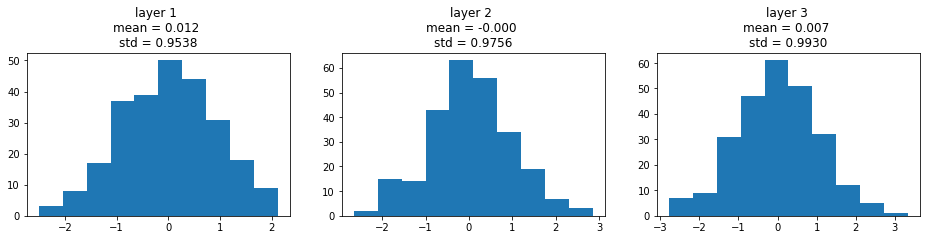

In [5]:
# Check the forward pass.
# Initialize a nerual net.
net_dims = [64, 256, 256, 256, 16]
params = {}
bn_params = []
for i in range(len(net_dims) - 1):
    params["W%d" % (i + 1)] = np.random.randn(net_dims[i], net_dims[i + 1]) * 1e-3
    params["b%d" % (i + 1)] = np.zeros(net_dims[i + 1])
    params["gamma%d" % (i + 1)] = np.ones(net_dims[i + 1])
    params["beta%d" % (i + 1)] = np.zeros(net_dims[i + 1])
    bn_params.append({"mode": "train"})


# Run the training-time forward pass many times to warm up the running averages.
num_examples = 16
for t in range(1024):
    in_data = np.random.randn(num_examples, net_dims[0])
    for i in range(len(net_dims) - 1):
        in_data, _ = affine_forward(in_data, params["W%d" % (i + 1)],
                                    params["b%d" % (i + 1)])
        in_data, _ = batchnorm_forward(in_data, params["gamma%d" % (i + 1)],
                                       params["beta%d" % (i + 1)],
                                       bn_params[i])
        in_data, _ = relu_forward(in_data)


# Check the means and variances of activations after a test-time forward pass.
for i in range(len(net_dims) - 1):
    bn_params[i]["mode"] = "test"
layers = {}
in_data = np.random.randn(num_examples, net_dims[0])
for i in range(len(net_dims) - 1):
    in_data, _ = affine_forward(in_data, params["W%d" % (i + 1)],
                                params["b%d" % (i + 1)])
    layers["%d" % (i + 1)], _ = batchnorm_forward(in_data, params["gamma%d" % (i + 1)],
                                                  params["beta%d" % (i + 1)],
                                                  bn_params[i])
    in_data, _ = relu_forward(layers["%d" % (i + 1)])


# Plot the activations.
# Means should be close to zero and stds close to one.
print("Layer inputs after batch normalization: ")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(net_dims) - 2):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(net_dims) - 2, i + 1)
    plt.hist(layers["%d" % (i + 1)][0])
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()

In [6]:
# Check the backward pass.
# Initialize toy data.
D = 32
num_classes = 10
x = np.random.randn(num_examples, D)
y = np.random.randint(low=1, high=num_classes, size=num_examples)

# Initialize the weights
W = np.random.randn(D, num_classes)
b = np.random.randn(num_classes)
gamma = np.random.randn(D)
beta = np.random.randn(D)
params = {"x":x, "gamma":gamma, "beta":beta}


# Using numeric gradient checking to check the implementation of the backward pass.
# If the implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of the model parameters.
norm_out, norm_cache = batchnorm_forward(x, gamma, beta, bn_param={"mode": "train"})
out, cache = affine_forward(norm_out, W, b)
_, dout = cross_entropy_loss(out, y)
dout, _, _ = affine_backward(dout, cache)
dx, dgamma, dbeta = batchnorm_backward(dout, norm_cache)
grads = {"x":dx, "gamma":dgamma, "beta":dbeta}

# These should all be less than 1e-8 or so.
f = lambda a: cross_entropy_loss(affine_forward(batchnorm_forward(x, gamma, beta, bn_param={"mode": "train"})[0],
                                          W, b)[0], y)[0]
for _name in grads:
    grad_numeric = eval_numerical_gradient(f, params[_name], verbose=False)
    print("%s max relative error: %e" % (_name, rel_error(grad_numeric, grads[_name])))

x max relative error: 1.217850e-06
gamma max relative error: 2.574662e-09
beta max relative error: 2.237326e-09


## Spatial Batch Norm

Batch normalization can also be used for convolutional neural networks, but it needs to be tweaked a bit. This modification might be called <i>Spatial Batch Normalization</i>.  
Normally, BatchNorm layers accept inputs of shape $ (m, D) $, where $ m $ is the mini-batch size, and $ D $ is the number of features, and the normalization is done accross all examples in the mini-batch. In conv nets BatchNorm layers need to accept inputs of shape $ (m, C, H, W) $, where $ C $ is the number of channels, and $ H $ and $ W $ give the spatial dimensions of the feature map. We want different elements of the same feature map, at different locations, to be normalized in the same way. Thus, we will compute a mean and variance for every channel $ C $ by computing statistics over both the elements of the mini-batch and the spatial locations. Effectively, we use a mini-batch of size $ m' = mHW $.  
The reason we compute the mean and the variance in this ways is because we expect means and variances computed at different locations of the same feature map to be relatively consistent between different image inputs. This is because every location of the feature map is produced by the same convolutional filter.

![Spatial BatchNorm](img/batchnorm_spatial.png "Spatial BatchNorm")

In [7]:
# Make some experiments to see that this is truly the case.
# Namely, that means and variances computed at different locations of the same feature map
# are relatively consistent between different image inputs.

## Layer Norm

BatchNorm exhibits drawbacks that are caused by its distinct behaviour of normalizing along the batch dimension. The effect of batch normalization greatly depends on the mini-batch size. Reducing the batch size leads to inaccurate estimation of the batch statistics and this in turn increases the model error dramatically. This dependancy makes it less useful in complex networks which have a cap on the input batch size due to hardware limitations.  
Another problem is that BatchNorm requires keeping running averages in order to run a forward pass at test-time. In feed-forward networks with fixed depth, it is straightforward to store the statistics separately for each hidden layer. However, applying batch normalization to Recurrent Neural Networks requires computing sums of varying lengths depending the length of the sequence.

A simple solution, called <i>Layer nomralization</i>, is proposed, that suggests computing the mean and variance over the hidden units in the same layer. Thus for a given layer we have:

$$ \begin{align*}
& \mu_{L} = \frac{1}{H} \sum_{i=1}^{H} u_{i} \\
& \upsilon_{L} = \frac{1}{H} \sum_{i=1}^{H} (u_{i} - \mu_{L})^{2}
\end{align*} $$

In other words, instead of normalizing over the batch, we normalize over the neurons in the given layer. Unlike batch normalization, layer normalization does not impose any constraint on the size of a mini-batch and it can be used in the pure online regime with batch size of 1. Another difference is that we dont keep track of running averages and the testing phase is identical to the training phase.

![LayerNorm](img/batchnorm_layernorm.png "LayerNorm")

Layer inputs after layer normalization: 


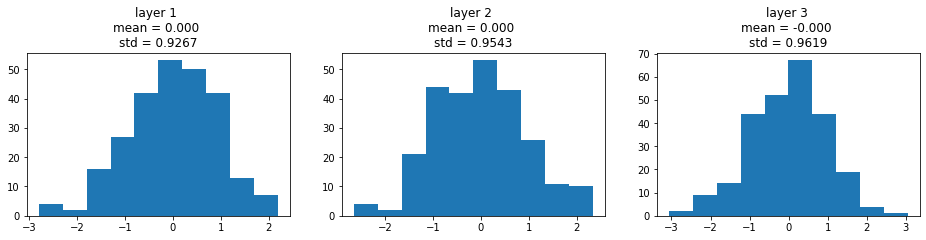

In [8]:
# Check the forward pass.
# Initialize a nerual net.
net_dims = [64, 256, 256, 256, 16]
params = {}
for i in range(len(net_dims) - 1):
    params["W%d" % (i + 1)] = np.random.randn(net_dims[i], net_dims[i + 1]) * 1e-3
    params["b%d" % (i + 1)] = np.zeros(net_dims[i + 1])
    params["gamma%d" % (i + 1)] = np.ones(net_dims[i + 1])
    params["beta%d" % (i + 1)] = np.zeros(net_dims[i + 1])


# Check the means and variances of activations after a forward pass.
layers = {}
in_data = np.random.randn(num_examples, net_dims[0])
for i in range(len(net_dims) - 1):
    in_data, _ = affine_forward(in_data, params["W%d" % (i + 1)],
                                params["b%d" % (i + 1)])
    layers["%d" % (i + 1)], _ = layernorm_forward(in_data, params["gamma%d" % (i + 1)],
                                                  params["beta%d" % (i + 1)], {})
    in_data, _ = relu_forward(layers["%d" % (i + 1)])


# Plot the activations.
# Means should be close to zero and stds close to one.
print("Layer inputs after layer normalization: ")
plt.subplots(figsize=(16.0, 3.0))
for i in range(len(net_dims) - 2):
    mean = np.mean(layers["%d" % (i + 1)])
    std = np.std(layers["%d" % (i + 1)])
    plt.subplot(1, len(net_dims) - 2, i + 1)
    plt.hist(layers["%d" % (i + 1)][0])
    plt.title("layer %d \nmean = %.3f \nstd = %.4f" % (i + 1, mean, std))
plt.show()

In [9]:
# Check the backward pass.
# Initialize toy data.
D = 32
num_classes = 10
x = np.random.randn(num_examples, D)
y = np.random.randint(low=1, high=num_classes, size=num_examples)

# Initialize the weights
W = np.random.randn(D, num_classes)
b = np.random.randn(num_classes)
gamma = np.random.randn(D)
beta = np.random.randn(D)
params = {"x":x, "gamma":gamma, "beta":beta}


# Using numeric gradient checking to check the implementation of the backward pass.
# If the implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of the model parameters.
norm_out, norm_cache = layernorm_forward(x, gamma, beta, {})
out, cache = affine_forward(norm_out, W, b)
_, dout = cross_entropy_loss(out, y)
dout, _, _ = affine_backward(dout, cache)
dx, dgamma, dbeta = layernorm_backward(dout, norm_cache)
grads = {"x":dx, "gamma":dgamma, "beta":dbeta}

# These should all be less than 1e-8 or so.
f = lambda a: cross_entropy_loss(affine_forward(layernorm_forward(x, gamma, beta, {})[0],
                                          W, b)[0], y)[0]
for _name in grads:
    grad_numeric = eval_numerical_gradient(f, params[_name], verbose=False)
    print("%s max relative error: %e" % (_name, rel_error(grad_numeric, grads[_name])))

x max relative error: 1.035731e-06
gamma max relative error: 1.403842e-09
beta max relative error: 9.737706e-10


## Group Norm

When used with convolutional layers Layer Normalization does not perform as well as Batch Normalization. An observation made by the authors of [2] is that with fully connected layers all the hidden units in a layer tend to make similar contributions to the final prediction and re-centering and re-scaling the summed inputs to a layer works well. However, the assumption of similar contributions is no longer true for convolutional neural networks. The large number of hidden units whose receptive fields lie near the boundary of the image are rarely turned on and thus have very different statistics from the rest of the hidden units within the same layer.

Group normalization is an intermediary technique for normalizing inputs of shape $ (m, C, H, W) $. In contrast to Layer Normalization, where you would normalize over all the channels per-datapoint, in Group Normalization the channels per-datapoint are split into $ G $ groups, and the normalization is per-group per-datapoint.

![GroupNorm](img/batchnorm_groupnorm.png "GroupNorm")

The mean and the variance of a feature $ u^{(k)} $ are computed as follows:

$$ \begin{align*}
& \mu_{G} = \frac{1}{|G|} \sum_{i \in G} u_{i} \\
& \upsilon_{G}^{(k)} = \frac{1}{|G|} \sum_{i \in G} (u_{i} - \mu_{G})^{2} \\
\end{align*} $$

In this setting, within each group an assumption of equal contribution is being made. However, according to the authors of [3], this assumption is not as problematic.  
One example they use to illustrate this is that many high-performance handcrafted features in traditional Computer Vision have terms that are explicitly grouped together. Take for example Histogram of Oriented Gradients [4]-- after computing histograms per spatially local block, each per-block histogram is normalized before being concatenated together to form the final feature vector.

Obviously, if we set the group number $ G = 1 $ then Group Norm becomes Layer Norm. It assumes that <i>all</i> channels in a layer make "similar contributions".  
Alternatively, if we set $ G = C $ (i.e. one channel per group), then Group Norm becomes Instance Norm. But Instance Norm can only rely on the spatial dimension for computing the mean and variance and it misses the opportunity of exploiting the channel dependance.